In [ ]:
import random
import numpy as np
import pandas as pd
import seaborn as sns

from IPython.display import display, Math, Latex
from matplotlib import pyplot as plt

In [ ]:
# Вот тут начинается наш проект

In [ ]:
from os import listdir
from os.path import isfile, join
onlyfiles = ['Chuhrov/thousand_arm_shiva/data/' +f for f in listdir('Chuhrov/thousand_arm_shiva/data') if isfile(join('Chuhrov/thousand_arm_shiva/data', f))]
#Создает список onlyfiles, который содержит полные пути к каждому файлу в указанном каталоге.

In [ ]:
q = 'Chuhrov/thousand_arm_shiva/data/YNDX_H1.csv'

df = pd.read_csv(q, parse_dates=['datetime'], index_col='datetime')
df = df.reindex(ind)
df = df.fillna(method='ffill') #Заполняет пропущенные значения с использованием метода "впереди" (forward fill),
#что означает, что пропуски заполняются последним доступным значением.
df = df.sort_index()
df = df.loc['2023-06-01 00:00:00':]
df

,open,high,low,close,volume
datetime,,,,,
2023-06-01 10:00:00,2328.0,2356.0,2318.0,2343.6,143039
2023-06-01 11:00:00,2343.2,2348.0,2333.2,2333.2,48477
2023-06-01 12:00:00,2333.2,2334.2,2304.8,2311.4,86184
2023-06-01 13:00:00,2313.2,2336.4,2294.8,2330.0,104030
2023-06-01 14:00:00,2329.2,2333.6,2316.0,2326.8,33793
...,...,...,...,...,...
2024-06-14 19:00:00,4070.0,4103.0,4068.0,4097.0,17247
2024-06-14 20:00:00,4097.0,4109.6,4090.0,4101.0,14093
2024-06-14 21:00:00,4101.0,4106.0,4094.6,4103.2,11230


In [ ]:
# ind = df.index.to_list()
df_a = df.reindex(ind)
df_a = df_a.fillna(method='ffill')
df_a[df_a['close'].isna()]

,open,high,low,close,volume
datetime,,,,,


In [ ]:
df_a

,open,high,low,close,volume
datetime,,,,,
2023-06-01 10:00:00,2328.0,2356.0,2318.0,2343.6,143039.0
2023-06-01 11:00:00,2343.2,2348.0,2333.2,2333.2,48477.0
2023-06-01 12:00:00,2333.2,2334.2,2304.8,2311.4,86184.0
2023-06-01 13:00:00,2313.2,2336.4,2294.8,2330.0,104030.0
2023-06-01 14:00:00,2329.2,2333.6,2316.0,2326.8,33793.0
...,...,...,...,...,...
2024-08-27 19:00:00,4092.2,4096.4,4071.2,4071.2,9576.0
2024-08-27 20:00:00,4092.2,4096.4,4071.2,4071.2,9576.0
2024-08-27 21:00:00,4092.2,4096.4,4071.2,4071.2,9576.0


In [ ]:
onlyfiles[112]

'Chuhrov/thousand_arm_shiva/data/TGKB_H1.csv'

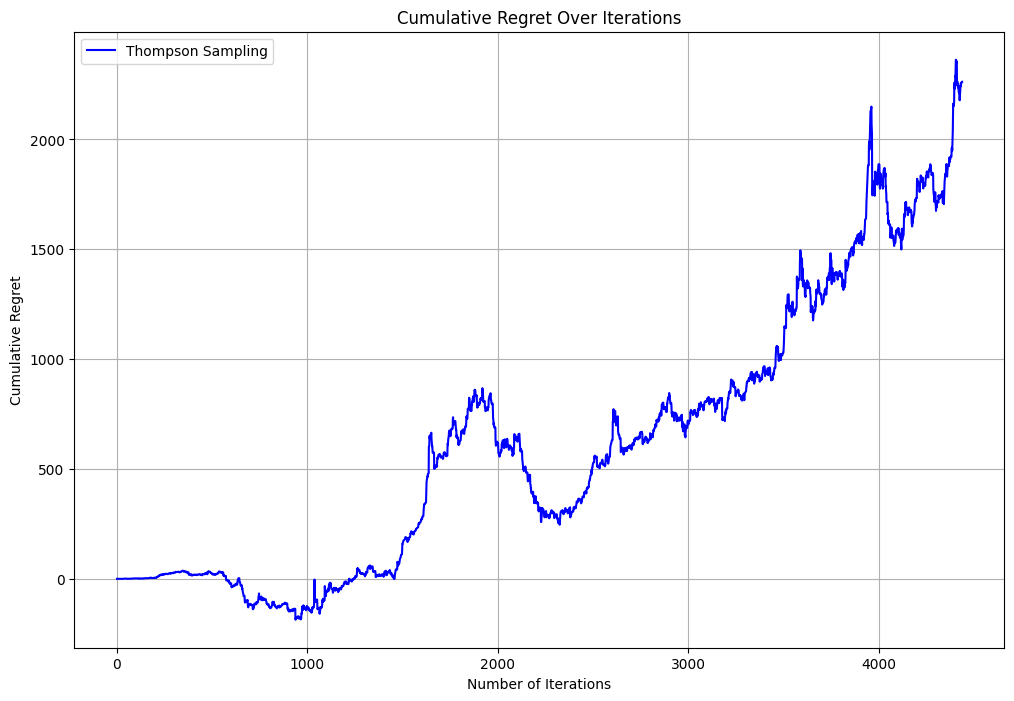

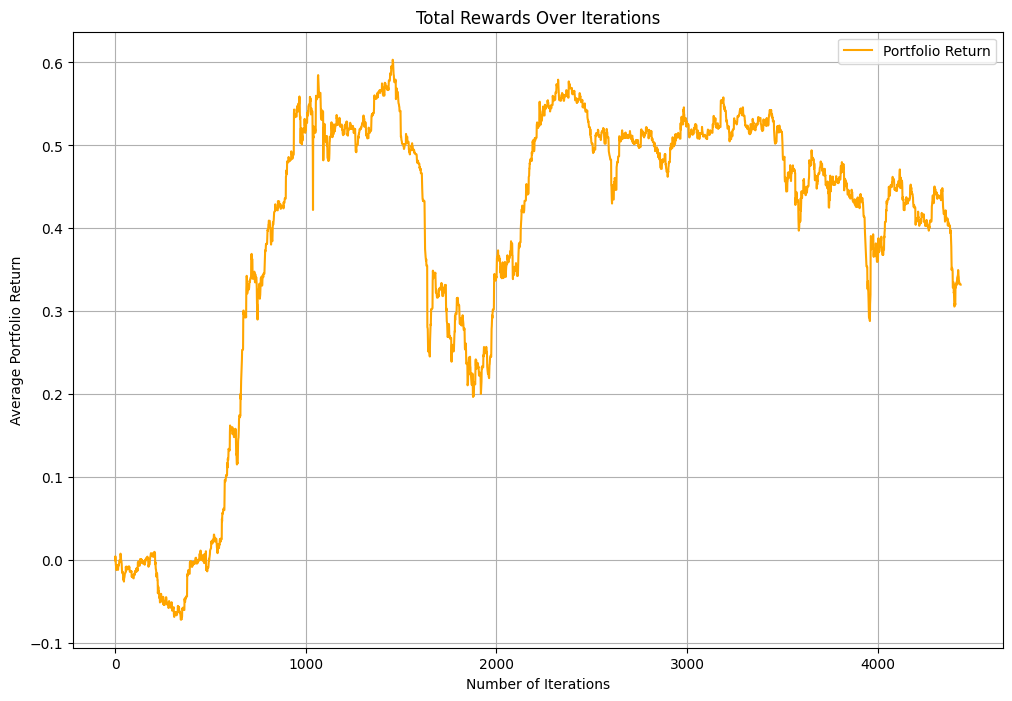

In [ ]:
#Код реализует алгоритм выбора акций на основе стратегии многорукого бандита с использованием Thompson Sampling.
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

df = pd.read_csv('Chuhrov/thousand_arm_shiva/data/SBER_H1.csv', parse_dates=['datetime'], index_col='datetime')
df = df.loc['2023-06-01 00:00:00':]
ind = df.index.to_list()

# Strategy Abstract Class
class Strategy:
    def __init__(self, n_arms: int, n_portfolio: int):
        self.n_arms = n_arms
        self.n_portfolio = n_portfolio
        self.n_iters = 0
        self.arms_states = np.zeros(n_arms)  # State for each arm
        self.arms_actions = np.zeros(n_arms)  # Action counts for each arm

    def flush(self):
        self.n_iters = 0
        self.arms_states = np.zeros(self.n_arms)
        self.arms_actions = np.zeros(self.n_arms)

    def update_reward(self, arm: int, reward: float):
        self.n_iters += 1
        self.arms_states[arm] += reward
        self.arms_actions[arm] += 1

    def choose_arm(self):
        raise NotImplementedError


# Thompson Sampling Strategy
class Thompson(Strategy):
    def __init__(self, n_arms: int, n_portfolio: int):
        super().__init__(n_arms, n_portfolio) #Количество доступных акций (или "рук"), из которых можно выбирать.
        #Количество акций, которые будут выбраны для портфеля в каждый момент времени.
        self.alphas = np.ones(self.n_arms)  # шанс на успех
        self.betas = np.ones(self.n_arms)   # шанс на неудачу

    def choose_arm(self):
        sampled_values = [np.random.beta(self.alphas[i], abs(self.betas[i])) for i in range(self.n_arms)]
        best_arms = np.argsort(sampled_values)[-self.n_portfolio:]  # Select the top stocks
        # print(best_arms)
        return best_arms

  # Сначала для каждой акции рассчитывается значение, извлекаемое из бета-распределения, параметры которого определяются массивами alphas и betas.
  # Затем с использованием функции np.argsort() определяется индексы акций, которые имеют наибольшие сэмплированные значения.
  # Метод возвращает индексы акций, отобранных для включения в портфель на текущий момент времени.

    def update_reward(self, arm: int, reward: float):
        super().update_reward(arm, reward)
        self.alphas[arm] += reward  # successes Если полученная награда (доходность) положительная, увеличивается соответствующее значение в массиве alphas (представляющее успехи).
        if reward < 0:
            self.betas[arm] += reward  # failures
        else:
            self.betas[arm] += 0


# Environment for Stock Market with CSV data
# Класс StockMarketEnv реализует среду для работы с акциями на финансовом рынке.
#Он предоставляет функциональность для загрузки данных по акциям, вычисления
#ожидаемых доходностей и получения случайных выборок доходностей для конкретных акций (или "рук")
class StockMarketEnv:
    def __init__(self, stock_files: list):
        self.stock_data = self.load_stock_data(stock_files)
        self.n_arms = len(self.stock_data)

    def load_stock_data(self, stock_files): #Метод загружает данные о акциях из переданных файлов и обрабатывает их
        data = {}
        for stock_file in stock_files:
            df = pd.read_csv(stock_file, parse_dates=['datetime'], index_col='datetime')
            df = df.reindex(ind)
            df = df.fillna(method='ffill')
            df = df.sort_index()
            df = df.loc['2023-06-01 00:00:00':]
            if df['close'].isna().sum() == 0:
                df['return'] = df['close'].pct_change() # Calculate returns based on the close price
                data[stock_file] = df['return'].dropna()    # Keep only valid return
        return data

    def get_expected_returns(self, i):
        # Метод рассчитывает ожидаемые доходности для каждой акции
        return np.array([self.stock_data[file][:i-1].mean() for file in self.stock_data])

    def pull_arm(self, arm_id: int, inde):
        # Метод выполняет выборку доходности для конкретной акции
        stock_file = list(self.stock_data.keys())[arm_id]
        try:
            return self.stock_data[stock_file][inde-1]
        except:
            print(self.stock_data[stock_file], inde)

# Bandit Mechanism
class Bandit:

    def __init__(self, env: StockMarketEnv, strategy: Strategy):
        self.env = env
        self.strategy = strategy

    def action(self, inde):
        arm = self.strategy.choose_arm()
        reward = self.env.pull_arm(arm, inde)
        self.strategy.update_reward(arm, reward)


strat = []
# Calculate Cumulative Regret and Collect Rewards
def calculate_regret(env: StockMarketEnv, strategy: Strategy):
    strategy.flush()
    bandit = Bandit(env, strategy)
    regrets = []
    total_rewards = []  # List to collect total rewards

    for i in range(len(ind)):
        expected_returns = env.get_expected_returns(i)  # Получение ожидаемых доходностей для текущего временного шага i.
        optimal_return = np.mean(expected_returns) # Среднее значение ожидаемых доходностей, которое используется для вычисления regret
        selected_stocks = bandit.strategy.choose_arm()  # Choose the best portfolio
        strat.append(selected_stocks)
        portfolio_return = np.mean([bandit.env.pull_arm(stock, i) for stock in selected_stocks]) #Вычисление среднестатистической доходности выбранного портфеля акций.

        cumulative_return = portfolio_return * (i + 1) #Общее накопительное вознаграждение за все итерации до текущей.
        cumulative_regret = optimal_return * (i + 1) - cumulative_return #Вычисление сожаления
        regrets.append(cumulative_regret)
        total_rewards.append(portfolio_return)

        for stock in selected_stocks:#Обновление вознаграждений для выбранных акций
            reward = bandit.env.pull_arm(stock, i)
            bandit.strategy.update_reward(stock, reward)

    return regrets, total_rewards

# Define the CSV files containing your stocks data
stock_files = onlyfiles  # Replace with your CSV paths

# Environment and Strategy Initialization
sm_env = StockMarketEnv(stock_files)  # Stock Market Environment
thompson = Thompson(sm_env.n_arms, n_portfolio=10)  # Thompson Sampling Strategy

# Regret Calculation
thompson_regrets, thompson_rewards = calculate_regret(sm_env, thompson)
df_regret = pd.DataFrame(None)
df_regret['regret'] = thompson_regrets
df_regret['regret_cum'] = df_regret['regret'].cumsum()
df_reward = pd.DataFrame(None)
df_reward['metric'] = thompson_rewards
df_reward['metric_cum'] = df_reward['metric'].cumsum()

# Plotting Regret
plt.figure(figsize=(12, 8))
plt.plot(df_regret['regret_cum'], label='Thompson Sampling', color='blue')
plt.title('Cumulative Regret Over Iterations')
plt.xlabel('Number of Iterations')
plt.ylabel('Cumulative Regret')
plt.grid()
plt.legend()
plt.show()

# Plotting Rewards
plt.figure(figsize=(12, 8))
plt.plot(df_reward['metric_cum'], label='Portfolio Return', color='orange')
plt.title('Total Rewards Over Iterations')
plt.xlabel('Number of Iterations')
plt.ylabel('Average Portfolio Return')
plt.grid()
plt.legend()
plt.show()

График кумулятивного рекорда:
На графике отображается, как с увеличением числа итераций растет кумулятивный рекорд. В начале наблюдается небольшое увеличение, но затем кумулятивный рекорд заметно возрастает. Это может указывать на то, что стратегия не всегда выбирала оптимальные акции, что приводит к упущенной прибыли. Некоторые пики могут быть результатом неудачных выборов в определенные моменты времени.

График общих вознаграждений:
Этот график показывает, как изменяется средняя доходность портфеля с течением времени. Наблюдается острая волатильность, и доходность колебалась, однако в целом сохраняется тенденция к росту. Пики на графике могут означать, что в определенные моменты времени портфель был успешным в выборе доходных акций.